<a href="https://colab.research.google.com/github/Minh-A/Bitcoin_fluctuation_prediction/blob/main/Fluctuation_Prediction_Beta4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 설명
* https://blog.naver.com/jeonghj66/222008532124
* https://blog.naver.com/naiy0404/222230337030


# 데이터 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt

# 성능지표
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as mt

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bnk/데이터/final_data_0601_3.csv', encoding='cp949')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 84 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     1202 non-null   object 
 1   Up/Down                  1202 non-null   object 
 2   원/달러(저가)                 1202 non-null   float64
 3   원/달러(종가)                 1202 non-null   float64
 4    open _x                 1202 non-null   int64  
 5    high _x                 1202 non-null   int64  
 6    low _x                  1202 non-null   int64  
 7    close _x                1202 non-null   int64  
 8   전일대비                     1202 non-null   int64  
 9   증감률                      1202 non-null   float64
 10   volume _x               1202 non-null   int64  
 11   value                   1202 non-null   float64
 12  MA(5)                    1202 non-null   int64  
 13  WMA(5)                   1202 non-null   int64  
 14  중심선                     

In [ ]:
data.head()

,date,Up/Down,원/달러(저가),원/달러(종가),open _x,high _x,low _x,close _x,전일대비,증감률,volume _x,value,MA(5),WMA(5),중심선,상한선,하한선,%B,band width,상승분,하락분,AU,AD,RS,RSI,12EMA,26EMA,MACD,MACD 시그널,%K,%D,open _y,high _y,low _y,close _y,volume _y,환률,원화환산,open,high,...,등락,등락률,market_premium,price_usd_open,price_usd_high,price_usd_low,price_usd_close,price_usd_adj_close,nvt_golden_cross,stock_to_flow,stock_to_flow_reversion,puell_multiple,stablecoin_supply_ratio,mpi,outflow_total,outflow_top10,outflow_mean,outflow_mean_ma7,reserve_x,reserve_usd_x,reserve_y,reserve_usd_y,reserve_bi,reserve_usd_bi,FGI,reserve_co,reserve_usd_co,reserve_der,reserve_usd_der,reserve_spot,reserve_usd_spot,reserve_all,reserve_usd_all,reserve,reserve_usd,파실 때,보내실 때,받으실 때,프리미엄%_업비트,프리미엄%_코인베이스
0,2018-02-01,Down,1068.5,1071.9,11439000,11490000,10011000,10070000,-1359000,-0.1189,22226,2.370000e+11,11877400,11341133,12472700,14525823,1.041958e+07,-0.09,0.33,0,1359000,261666.6667,642666.6667,0.407158,28.934759,12957482,15148589,-2191106,-1901065,1.657769,16.048295,10285.10,10335.00,8750.99,9224.52,33565,1072,9888685,10099.99,10166.25,...,1,1.34,51.312679,14.25,14.25,12.05,13.11,13.11,-0.974258,8419.788648,1.086884,1.784690,66.507798,0.001605,1596.374355,1546.358399,8.582658,2.540632,642450.9528,5879284961,642450.9528,5879284961,151633.7371,1.387651e+09,30,631190.6195,5776237860,642450.9528,5879284961,1393822.705,12755340828,2036273.658,1.863463e+10,642450.9528,5879284961,1344.300000,5.3,0.003900,1.843100,-2.2797
1,2018-02-02,Down,1070.7,1079.7,10061000,10120000,7830000,9410000,-660000,-0.0655,52018,4.660000e+11,11089000,10518667,12099600,14788820,9.410380e+06,0.00,0.44,0,660000,238000.0000,645142.8571,0.368911,26.949207,12411716,14723508,-2311792,-1983211,27.920127,20.679488,9224.52,9250.00,8010.02,8873.03,49972,1080,9582872,9014.22,9090.08,...,1,1.34,42.721911,11.89,13.10,11.64,12.00,12.00,-1.198093,8019.846331,1.103221,1.719647,64.552097,-0.615347,946.366655,890.894902,6.267329,3.326606,661565.8893,5853314467,661565.8893,5853314467,150398.1722,1.330673e+09,15,631669.5173,5588801332,661565.8893,5853314467,1398605.628,12374396391,2060171.517,1.822771e+10,661565.8893,5853314467,1333.700000,10.6,-0.007800,-1.776700,-0.9637
2,2018-02-03,Up,1070.7,1079.7,9410000,10200000,8400000,9520000,110000,0.0117,25406,2.360000e+11,10411200,9995667,11706600,14630024,8.783176e+06,0.13,0.50,110000,0,195333.3333,673166.6667,0.290171,22.490885,11966837,14338063,-2371226,-2060814,32.962746,20.846881,8873.03,9473.01,8229.00,9199.96,28725,1080,9935957,8787.52,9499.00,...,1,1.34,46.188354,11.58,12.44,10.96,11.35,11.35,-0.999548,8528.431542,1.067254,1.583934,67.256738,-0.947008,145.367410,122.518562,0.685695,3.184920,659549.6535,6003224244,659549.6535,6003224244,149015.1937,1.356337e+09,40,631970.2084,5752195997,659549.6535,6003224244,1397086.223,12716285790,2056635.877,1.871951e+10,659549.6535,6003224244,1333.466667,7.3,-0.005367,0.041433,-0.8096
3,2018-02-04,Down,1070.7,1079.7,9524000,10158000,8765000,8900000,-620000,-0.0651,18781,1.780000e+11,9865800,9491933,11299300,14522983,8.075617e+06,0.13,0.57,0,620000,195333.3333,760333.3333,0.256905,20.439484,11495016,13935244,-2440228,-2136697,26.289926,29.057600,9199.96,9368.00,7930.00,8184.81,32014,1080,8839595,9227.80,9350.00,...,1,1.34,49.654797,11.27,11.78,10.28,10.70,10.70,-1.121999,7571.180807,1.085739,1.693366,59.564491,-0.495010,1653.312875,1625.669332,5.134512,3.639219,681863.9489,5605143266,681863.9489,5605143266,144085.2127,1.184427e+09,24,632632.5583,5200445235,681863.9489,5605143266,1394810.224,11465793353,2076674.173,1.707094e+10,681863.9489,5605143266,1333.233333,4.0,-0.002933,1.859567,-0.6555
4,2018-02-05,Down,1087.6,1088.5,8900000,9250000,7715000,7832000,-1068000,-0.1200,20710,1.760000e+11,9146400,8814000,10794900,14426556,7.163244e+06,0.09,0.67,0,1068000,281000.0000,804285.7143,0.349378,25.891799,10931475,13483151,-2551677,-2219693,3.099338,20.784003,8179.99,8382.80,6625.00,6939.99,63403,1089,7557649,8167.90,8349.16,...,1,1.34,53.121239,10.96,11

선형 보간법

In [ ]:
# 선형 보간법으로 결측치를 없앰
data1 = data.interpolate(method="linear")

In [ ]:
data1.head(3)

,date,Up/Down,원/달러(저가),원/달러(종가),open _x,high _x,low _x,close _x,전일대비,증감률,volume _x,value,MA(5),WMA(5),중심선,상한선,하한선,%B,band width,상승분,하락분,AU,AD,RS,RSI,12EMA,26EMA,MACD,MACD 시그널,%K,%D,open _y,high _y,low _y,close _y,volume _y,환률,원화환산,open,high,...,등락,등락률,market_premium,price_usd_open,price_usd_high,price_usd_low,price_usd_close,price_usd_adj_close,nvt_golden_cross,stock_to_flow,stock_to_flow_reversion,puell_multiple,stablecoin_supply_ratio,mpi,outflow_total,outflow_top10,outflow_mean,outflow_mean_ma7,reserve_x,reserve_usd_x,reserve_y,reserve_usd_y,reserve_bi,reserve_usd_bi,FGI,reserve_co,reserve_usd_co,reserve_der,reserve_usd_der,reserve_spot,reserve_usd_spot,reserve_all,reserve_usd_all,reserve,reserve_usd,파실 때,보내실 때,받으실 때,프리미엄%_업비트,프리미엄%_코인베이스
0,2018-02-01,Down,1068.5,1071.9,11439000,11490000,10011000,10070000,-1359000,-0.1189,22226,2.370000e+11,11877400,11341133,12472700,14525823,1.041958e+07,-0.09,0.33,0,1359000,261666.6667,642666.6667,0.407158,28.934759,12957482,15148589,-2191106,-1901065,1.657769,16.048295,10285.10,10335.00,8750.99,9224.52,33565,1072,9888685,10099.99,10166.25,...,1,1.34,51.312679,14.25,14.25,12.05,13.11,13.11,-0.974258,8419.788648,1.086884,1.784690,66.507798,0.001605,1596.374355,1546.358399,8.582658,2.540632,642450.9528,5879284961,642450.9528,5879284961,151633.7371,1.387651e+09,30,631190.6195,5776237860,642450.9528,5879284961,1393822.705,12755340828,2036273.658,1.863463e+10,642450.9528,5879284961,1344.300000,5.3,0.003900,1.843100,-2.2797
1,2018-02-02,Down,1070.7,1079.7,10061000,10120000,7830000,9410000,-660000,-0.0655,52018,4.660000e+11,11089000,10518667,12099600,14788820,9.410380e+06,0.00,0.44,0,660000,238000.0000,645142.8571,0.368911,26.949207,12411716,14723508,-2311792,-1983211,27.920127,20.679488,9224.52,9250.00,8010.02,8873.03,49972,1080,9582872,9014.22,9090.08,...,1,1.34,42.721911,11.89,13.10,11.64,12.00,12.00,-1.198093,8019.846331,1.103221,1.719647,64.552097,-0.615347,946.366655,890.894902,6.267329,3.326606,661565.8893,5853314467,661565.8893,5853314467,150398.1722,1.330673e+09,15,631669.5173,5588801332,661565.8893,5853314467,1398605.628,12374396391,2060171.517,1.822771e+10,661565.8893,5853314467,1333.700000,10.6,-0.007800,-1.776700,-0.9637
2,2018-02-03,Up,1070.7,1079.7,9410000,10200000,8400000,9520000,110000,0.0117,25406,2.360000e+11,10411200,9995667,11706600,14630024,8.783176e+06,0.13,0.50,110000,0,195333.3333,673166.6667,0.290171,22.490885,11966837,14338063,-2371226,-2060814,32.962746,20.846881,8873.03,9473.01,8229.00,9199.96,28725,1080,9935957,8787.52,9499.00,...,1,1.34,46.188354,11.58,12.44,10.96,11.35,11.35,-0.999548,8528.431542,1.067254,1.583934,67.256738,-0.947008,145.367410,122.518562,0.685695,3.184920,659549.6535,6003224244,659549.6535,6003224244,149015.1937,1.356337e+09,40,631970.2084,5752195997,659549.6535,6003224244,1397086.223,12716285790,2056635.877,1.871951e+10,659549.6535,6003224244,1333.466667,7.3,-0.005367,0.041433,-0.8096


데이터 셋 분류

In [ ]:
# 상승, 하락에 굉장한 영향을 미치는 컬럼
mu = ['상승분','전일대비','증감률','전일대비.1','하락분']

# RF, LGBM, XGB로 뽑은 Top15개의 컬럼
top15_list=['%K','%B','mpi','outflow_mean','market_premium','%D','RS',' volume _y','volume','outflow_total','nvt_golden_cross','  value ','stock_to_flow',' volume _x','AU']

hab = ['date'	,'Up/Down', '상승분','전일대비','증감률','전일대비.1','하락분', '%K','%B','mpi','outflow_mean','market_premium','%D','RS',' volume _y','volume','outflow_total']

In [ ]:
# 데이터 확인
data1.loc[:,hab]

In [ ]:
# 훈련데이터 셋과 테스트데이터 셋을 분류
train = data1.iloc[:-37,:]
test = data1.iloc[-37:,:]

In [ ]:
# 각 데이터 셋에서 Feature와 label을 분류
train_feature = train.iloc[:,2:]
train_label = train.iloc[:,1]

test_feature = test.iloc[:,2:]
test_label = test.iloc[:,1]

원핫인코딩 처리

In [ ]:
# label은 원핫인코딩 처리
train_label1 = pd.get_dummies(train_label)
test_label1 = pd.get_dummies(test_label)

In [ ]:
test_label1.head(5)

,Down,Up
1165,0,1
1166,1,0
1167,0,1
1168,1,0
1169,1,0


데이터 정규화를 사용

In [ ]:
# 데이터 정규화 (MinMax정규화)
from sklearn.preprocessing import StandardScaler

# 훈련 데이터셋 feature
scaler = StandardScaler()

train_feature = scaler.fit_transform(train_feature)
train_feature = pd.DataFrame(train_feature)

# 테스트 데이터셋 feature
scaler = StandardScaler()

test_feature = scaler.fit_transform(test_feature)
test_feature1 = pd.DataFrame(test_feature)

train_feature.head(3), test_feature1.head(3)

(         0         1         2   ...        79        80        81
 0 -1.681571 -1.657008 -0.161469  ...  0.374276  0.444992 -3.193162
 1 -1.633331 -1.487252 -0.264609  ... -0.890423 -0.931055 -1.258786
 2 -1.633331 -1.487252 -0.313335  ... -0.627395 -0.239902 -1.032275
 
 [3 rows x 82 columns],
          0         1         2   ...        79        80        81
 0 -0.509035  0.275729  1.415893  ... -1.406463  1.715478  0.136704
 1  0.644749  0.885542  1.461128  ... -1.374195  1.660506  0.154986
 2  1.229766  1.050356  1.363367  ...  0.769325  0.726574  0.212356
 
 [3 rows x 82 columns])

In [ ]:
# # 데이터 정규화 (MinMax정규화)
# from sklearn.preprocessing import MinMaxScaler

# # 훈련 데이터셋 feature
# scaler = MinMaxScaler()

# train_feature = scaler.fit_transform(train_feature)
# train_feature = pd.DataFrame(train_feature)

# # 테스트 데이터셋 feature
# scaler = MinMaxScaler()

# test_feature = scaler.fit_transform(test_feature)
# test_feature1 = pd.DataFrame(test_feature)

# train_feature.head(3), test_feature1.head(3)

슬라이딩 윈도우 형태로 데이터를 변환

In [ ]:
# (배치 사이즈, 날짜, 속성)으로 데이터 셋을 생성
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
# 데이터 셋을 슬라이딩 윈도우 형식으로 만들기

# 훈련데이터 셋
train_feature1, train_label = make_dataset(train_feature, train_label1, 7)

#테스트 데이터 셋
test_feature, test_label = make_dataset(test_feature1, test_label1, 7)

x_train = train_feature1
y_train = train_label

x_train.shape, y_train.shape, test_label.shape

# # Validation 셋을 추가함
# from sklearn.model_selection import train_test_split
# x_train, x_valid, y_train, y_valid = train_test_split(train_feature1, train_label1, test_size=0.2, shuffle=False)

# x_train.shape, x_valid.shape, test_feature.shape, test_label.shape

((1158, 7, 82), (1158, 2), (30, 2))

# 모델링

## GRU 0.833

In [ ]:
# 모델 생성
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, GRU
import tensorflow as tf
tf.random.set_seed(2)

model = Sequential()

model.add(GRU(32, 
               input_shape=(train_feature1.shape[1], train_feature1.shape[2]), 
               activation='tanh', return_sequences = True))

model.add(GRU(64, 
              input_shape=(train_feature1.shape[1], train_feature1.shape[2]), 
               activation='tanh', return_sequences = True))

model.add(GRU(128, 
               activation='tanh', return_sequences = True))

model.add(GRU(256, 
               activation='tanh', return_sequences = True))

model.add(GRU(512, 
               activation='tanh'))

model.add(Dense(2, activation='softmax'))

In [ ]:
# 모델 확인
model.summary()

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_429 (GRU)                (None, 7, 32)             11136     
_________________________________________________________________
gru_430 (GRU)                (None, 7, 64)             18816     
_________________________________________________________________
gru_431 (GRU)                (None, 7, 128)            74496     
_________________________________________________________________
gru_432 (GRU)                (None, 7, 256)            296448    
_________________________________________________________________
gru_433 (GRU)                (None, 512)               1182720   
_________________________________________________________________
dense_87 (Dense)             (None, 2)                 1026      
Total params: 1,584,642
Trainable params: 1,584,642
Non-trainable params: 0
___________________________________________

In [ ]:
# 모델 학습
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=31, epochs=31)  

Epoch 1/31
38/38 [==============================] - 7s 9ms/step - loss: 0.6956 - accuracy: 0.5462
Epoch 2/31
38/38 [==============================] - 0s 8ms/step - loss: 0.6846 - accuracy: 0.5445
Epoch 3/31
38/38 [==============================] - 0s 8ms/step - loss: 0.6794 - accuracy: 0.5875
Epoch 4/31
38/38 [==============================] - 0s 8ms/step - loss: 0.6847 - accuracy: 0.5411
Epoch 5/31
38/38 [==============================] - 0s 8ms/step - loss: 0.6780 - accuracy: 0.5657
Epoch 6/31
38/38 [==============================] - 0s 8ms/step - loss: 0.6774 - accuracy: 0.5616
Epoch 7/31
38/38 [==============================] - 0s 8ms/step - loss: 0.6816 - accuracy: 0.5322
Epoch 8/31
38/38 [==============================] - 0s 8ms/step - loss: 0.6663 - accuracy: 0.5863
Epoch 9/31
38/38 [==============================] - 0s 8ms/step - loss: 0.6813 - accuracy: 0.5578
Epoch 10/31
38/38 [==============================] - 0s 8ms/step - loss: 0.6668 - accuracy: 0.5949
Epoch 11/31
38/38 [

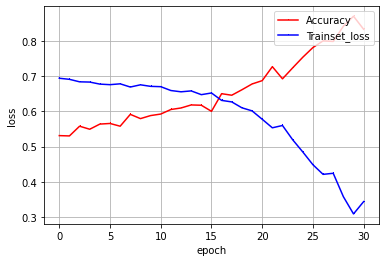

In [ ]:
# 모델 loss 그래프

y_test_loss = history.history['accuracy']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))
plt.plot(x_len, y_test_loss, marker=',', c='red', label='Accuracy')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

모델 예측

In [ ]:
# 모델 예측
pred = model.predict_classes(test_feature)
pred

array([0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0])

In [ ]:
# 모델 예측
pred = model.predict(test_feature)
pred

array([[8.0881846e-01, 1.9118159e-01],
       [9.9134141e-01, 8.6586308e-03],
       [4.3059808e-01, 5.6940192e-01],
       [2.9298672e-01, 7.0701331e-01],
       [9.9773542e-04, 9.9900228e-01],
       [6.5274409e-04, 9.9934727e-01],
       [9.8793632e-01, 1.2063613e-02],
       [9.9656904e-01, 3.4309535e-03],
       [1.2974857e-04, 9.9987018e-01],
       [2.5185937e-01, 7.4814057e-01],
       [8.5479990e-03, 9.9145198e-01],
       [6.0280329e-01, 3.9719668e-01],
       [7.9727155e-01, 2.0272847e-01],
       [9.9981242e-01, 1.8759303e-04],
       [9.9950159e-01, 4.9835793e-04],
       [7.4831116e-01, 2.5168881e-01],
       [7.9048824e-01, 2.0951179e-01],
       [9.2898391e-04, 9.9907100e-01],
       [9.9984944e-01, 1.5054875e-04],
       [8.8120276e-01, 1.1879724e-01],
       [9.5007926e-01, 4.9920730e-02],
       [9.9996281e-01, 3.7184047e-05],
       [5.0565931e-03, 9.9494344e-01],
       [5.5928499e-01, 4.4071504e-01],
       [9.1953903e-01, 8.0460936e-02],
       [2.3869454e-05, 9.

예측값을 원핫인코딩으로 전환

In [ ]:
# 위치를 숫자로 반환
preds = np.argmax(pred, axis=1)
preds

array([0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0])

In [ ]:
# 원핫인코딩
preds1 = pd.get_dummies(preds)
preds1

,0,1
0,1,0
1,1,0
2,0,1
3,0,1
4,0,1
5,0,1
6,1,0
7,0,1
8,0,1
9,0,1


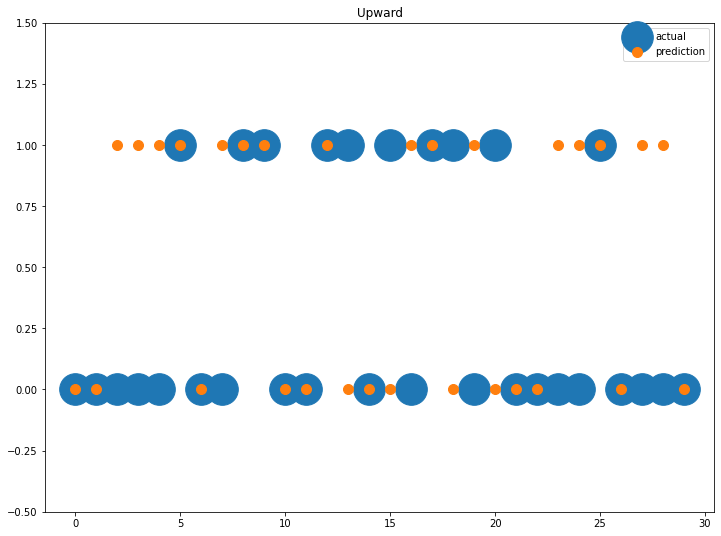

In [ ]:
plt.figure(figsize=(12, 9))
plt.scatter(pd.DataFrame(test_label).index, test_label[:,1], label = 'actual', s = 1000)
plt.scatter(pd.DataFrame(test_label).index, preds1[1], label = 'prediction', s = 100)
plt.ylim([-0.5, 1.5])
plt.title("Upward") 
plt.legend()
plt.show()

성능지표

In [ ]:
test_label1 = np.array(test_label).argmax(axis=1)

# 성능평가: 하나로 묶어서
print('accuracy',mt.accuracy_score(test_label1,preds))
print(confusion_matrix(test_label1, preds))
print(classification_report(test_label1, preds, target_names=['하락', '상승']))

accuracy 0.5333333333333333
[[10 10]
 [ 4  6]]
              precision    recall  f1-score   support

          하락       0.71      0.50      0.59        20
          상승       0.38      0.60      0.46        10

    accuracy                           0.53        30
   macro avg       0.54      0.55      0.52        30
weighted avg       0.60      0.53      0.55        30



# 반복문

In [ ]:
# 모델 생성
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, GRU
import tensorflow as tf

In [ ]:
epoch = [29,30,31,32,33,34,35,36,37, 38, 39, 40, 41]

for i in epoch:

  for j in range(50):

    print('\n', i)
    print('몇 번 돌림', j)

  
    model = Sequential()

    model.add(GRU(32, 
               input_shape=(train_feature1.shape[1], train_feature1.shape[2]), 
               activation='tanh', return_sequences = True))

    model.add(GRU(64, 
              input_shape=(train_feature1.shape[1], train_feature1.shape[2]), 
               activation='tanh', return_sequences = True))

    model.add(GRU(128, 
               activation='tanh', return_sequences = True))

    model.add(GRU(256, 
               activation='tanh', return_sequences = True))

    model.add(GRU(512, 
               activation='tanh'))

    model.add(Dense(2, activation='softmax'))


    # 학습
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(x_train, y_train, batch_size=62, epochs=i, verbose=0)  


    # 예측
    pred = model.predict(test_feature)

    model.save('/content/drive/MyDrive/Colab Notebooks/bnk/모델1/mnist_mlp_model{}{}.h5'.format(i,j))

    preds = np.argmax(pred, axis=1)

    preds1 = pd.get_dummies(preds)

    plt.figure(figsize=(12, 9))
    plt.scatter(pd.DataFrame(test_label).index, test_label[:,1], label = 'actual', s = 1000, c = 'b')
    plt.scatter(pd.DataFrame(test_label).index, preds1[1], label = 'prediction', s= 100, c = 'red')
    plt.ylim([-0.5, 1.5])
    plt.title("Upward") 
    plt.legend()
    plt.show()

    test_label1 = np.array(test_label).argmax(axis=1)

    # 성능평가: 하나로 묶어서
    print('accuracy',mt.accuracy_score(test_label1,preds))
    print(confusion_matrix(test_label1, preds))
    print(classification_report(test_label1, preds, target_names=['하락', '상승']))


 29
몇 번 돌림 0


NameError: ignored

In [ ]:
# 모델 생성
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, GRU, SimpleRNN
import tensorflow as tf

In [ ]:
epoch = [30,31,32, 33]

for i in epoch:

  for j in range(30):

    print('\n', i)
    print('몇 번 돌림', j)

  
    model = Sequential()

    model.add(GRU(32, 
               input_shape=(train_feature1.shape[1], train_feature1.shape[2]), 
               activation='tanh', return_sequences = True))

    model.add(GRU(64, 
              input_shape=(train_feature1.shape[1], train_feature1.shape[2]), 
               activation='tanh', return_sequences = True))

    model.add(GRU(128, 
               activation='tanh', return_sequences = True))

    model.add(GRU(256, 
               activation='tanh', return_sequences = True))

    model.add(GRU(512, 
               activation='tanh'))

    model.add(Dense(2, activation='softmax'))


    # 학습
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(x_train, y_train, batch_size=62, epochs=i, verbose=0)  


    # 예측
    pred = model.predict(test_feature)

    model.save('/content/drive/MyDrive/Colab Notebooks/bnk/모델1/mnist_model{}{}.h5'.format(i,j))

    preds = np.argmax(pred, axis=1)

    preds1 = pd.get_dummies(preds)



    test_label1 = np.array(test_label).argmax(axis=1)

    # 성능평가: 하나로 묶어서
    print('accuracy',mt.accuracy_score(test_label1,preds))
    print(confusion_matrix(test_label1, preds))
    print(classification_report(test_label1, preds, target_names=['하락', '상승']))


 30
몇 번 돌림 0
accuracy 0.43333333333333335
[[ 8 12]
 [ 5  5]]
              precision    recall  f1-score   support

          하락       0.62      0.40      0.48        20
          상승       0.29      0.50      0.37        10

    accuracy                           0.43        30
   macro avg       0.45      0.45      0.43        30
weighted avg       0.51      0.43      0.45        30


 30
몇 번 돌림 1
accuracy 0.5666666666666667
[[11  9]
 [ 4  6]]
              precision    recall  f1-score   support

          하락       0.73      0.55      0.63        20
          상승       0.40      0.60      0.48        10

    accuracy                           0.57        30
   macro avg       0.57      0.57      0.55        30
weighted avg       0.62      0.57      0.58        30


 30
몇 번 돌림 2
accuracy 0.6666666666666666
[[12  8]
 [ 2  8]]
              precision    recall  f1-score   support

          하락       0.86      0.60      0.71        20
          상승       0.50      0.80      0.62        10

KeyboardInterrupt: ignored

# 저장 모델 불러오기

In [ ]:
from keras.models import load_model
model1 = load_model('/content/drive/MyDrive/Colab Notebooks/bnk/활용 모델/GRU_FullVariables_0.73_model3225.h5')

In [ ]:
model1.summary()

Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_675 (GRU)                (None, 7, 32)             11136     
_________________________________________________________________
gru_676 (GRU)                (None, 7, 64)             18816     
_________________________________________________________________
gru_677 (GRU)                (None, 7, 128)            74496     
_________________________________________________________________
gru_678 (GRU)                (None, 7, 256)            296448    
_________________________________________________________________
gru_679 (GRU)                (None, 512)               1182720   
_________________________________________________________________
dense_135 (Dense)            (None, 2)                 1026      
Total params: 1,584,642
Trainable params: 1,584,642
Non-trainable params: 0
__________________________________________

In [ ]:
pred = model1.predict(test_feature)

preds = np.argmax(pred, axis=1)

preds1 = pd.get_dummies(preds)

test_label1 = np.array(test_label).argmax(axis=1)

# 성능평가: 하나로 묶어서
print('accuracy',mt.accuracy_score(test_label1,preds))
print(confusion_matrix(test_label1, preds))
print(classification_report(test_label1, preds, target_names=['하락', '상승']))

accuracy 0.7333333333333333
[[14  6]
 [ 2  8]]
              precision    recall  f1-score   support

          하락       0.88      0.70      0.78        20
          상승       0.57      0.80      0.67        10

    accuracy                           0.73        30
   macro avg       0.72      0.75      0.72        30
weighted avg       0.77      0.73      0.74        30

